# Make Canoeing Map
Make a canoeing map using OpenStreetMap data.
- get OSM data for desired using OSMNx
- get background tiles for map
- assembple it all together using Matplotlib


In [1]:
import pandas as pd
import json
import numpy as np
import geopandas as gpd
import contextily as cx
import geopy.distance
from shapely.geometry import MultiPolygon, Polygon, Point, LineString
import osmnx as ox
import pyproj
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import patches

%matplotlib inline

In [2]:

from src.map_utils import *

In [3]:
# Load nation lakes coords   
with open("nation_lakes.json") as f:
    lakes = json.load(f)
print("\nlakes:")
for i,lake in enumerate(lakes):
    print(i,lake["name"])


lakes:
0 Tsayta Lake
1 Indata Lake
2 Tchentlo Lake
3 Chuchi Lake


In [4]:
place = lakes[2]
place_name = place["name"].replace(" ", "-")
print(place["name"])

with open("osm_tags.json") as f:
    desired_tags = json.load(f)
print(json.dumps(desired_tags, indent=2))

Tchentlo Lake
{
  "leisure": [
    "park",
    "nature_reserve"
  ],
  "tourism": [
    "camp_site"
  ],
  "highway": [
    "motorway",
    "trunk",
    "primary",
    "secondary",
    "tertiary",
    "unclassified",
    "track",
    "road",
    "path",
    "footway"
  ],
  "water": [
    "lake",
    "river"
  ]
}


In [5]:
gdf = ox.features.features_from_bbox(place["north"], place["south"], place["east"], place["west"], desired_tags)
gdf = gdf.to_crs(epsg=3857) # project to spherical mercator to match tiles
gdf.reset_index(inplace=True)
cols_to_keep = ['element_type', 'geometry', 'name'] + [key for key in desired_tags.keys() if key in gdf.columns]
gdf = gdf[cols_to_keep]
elements = gdf.to_dict(orient = "records")
gdf

,element_type,geometry,name,leisure,tourism,highway,water
0,node,POINT (-13927251.135 7397750.565),NaN,NaN,camp_site,NaN,NaN
1,node,POINT (-13893037.802 7401149.038),Ahdatay,NaN,camp_site,NaN,NaN
2,node,POINT (-13897530.267 7405154.215),Ahdatay Creek Provincial Site,NaN,camp_site,NaN,NaN
3,node,POINT (-13902276.529 7402844.979),Miner's Camp,NaN,camp_site,NaN,NaN
4,node,POINT (-13903632.690 7405950.229),NaN,NaN,camp_site,NaN,NaN
5,node,POINT (-13905395.523 7404803.671),Pine Point,NaN,camp_site,NaN,NaN
6,node,POINT (-13909000.004 7403426.024),NaN,NaN,camp_site,NaN,NaN
7,node,POINT (-13911881.920 7399091.207),NaN,NaN,camp_site,NaN,NaN
8,node,POINT (-13921971.006 7400055.029),NaN,NaN,camp_site,NaN,NaN
9,node,POINT (-13929125.632 7397623.363),Progress Point,NaN,camp_site,NaN,NaN


# Get background tiles

In [16]:
west,east,south,north = place["west"], place["east"], place["south"], place["north"]
zoom_level = cx.tile._calculate_zoom(west,south,east,north) + 1  


STAMEN_API_KEY = os.environ["STAMEN_API_KEY"]
with open("tiles.json") as f:
    tiles = json.load(f)
print(tiles.keys())
tiles_source = tiles["StamenTonerLite"].replace("API_KEY", STAMEN_API_KEY)
# tiles_source = tiles["StamenTerrain"].replace("API_KEY", STAMEN_API_KEY)
img, ext = cx.bounds2raster(west,south, east, north, f"cache/{place_name}.tif", zoom_level, source=tiles_source, ll=True)


dict_keys(['StamenToner', 'StamenTonerLite', 'StamenTerrain', 'StamenWatercolor', 'GoogleMaps', 'GoogleSatellite', 'GoogleSatelliteHybrid', 'EsriSatellite'])


In [7]:
# convert to EPSG3857
x_min, y_min = lonlat_to_xy(west, south)
x_max, y_max = lonlat_to_xy(east, north) 
dy = y_max - y_min
dx = x_max - x_min


plot_dim = 10
figsize = calculate_plot_dimensions(plot_dim, dx, dy)
figsize

(10, 3.742437339966413)

In [8]:
node_marker_size = plot_dim * 0.5
annotation_text_size = plot_dim * 0.5
thick_line_width = plot_dim * 0.1
med_line_width = plot_dim * 0.05
thin_line_width = plot_dim * 0.025

styles = {
    "main_road": {"color":"gray", "linewidth":thick_line_width},
    "secondary_road": {"color":"gray", "linewidth":med_line_width},
    "tertiary_road": {"color":"gray", "linewidth":thin_line_width},
    "trail":{"color":"gray", "linewidth":thin_line_width, "linestyle": "--"},
    "campsite": {"marker": "o", "ms": node_marker_size, "mew":0.5, "mfc":"none", "mec":"green", "alpha": 0.9, "linestyle": "",},
    "lake": {"color":"blue", "linewidth":thin_line_width, "alpha": 0.8},
    "river": {"color":"blue", "linewidth":thin_line_width, "alpha": 0.5},
    "mountain": {"marker": "+", "ms": node_marker_size*0.5, "color":"black", "mew":0.5, "mfc":"none","linestyle": ""},
    "attraction": {"marker": "*", "ms": node_marker_size*0.5, "mfc":"none", "mec":"blue", "alpha": 0.5, "linestyle": ""},
    "park": {"color":"green", "linewidth":thick_line_width, "linestyle": ":", "alpha":0.5},
}

In [9]:
tag_styles = {
    "tourism": {
        "camp_site": "campsite"
    },
    "natural": {
        "peak": "mountain",
        "mountain_range": "mountain",
        "spring": "attraction",
    },
    "barrier": {
        "yes": "barrier",
    },
    "water": {
        "lake": "lake",
        "river": "river",
    },
    'highway': {
        "motorway": "secondary_road",
        "trunk":  "secondary_road",
        "primary": "secondary_road",
        "secondary": "tertiary_road",
        "tertiary": "tertiary_road",
        "unclassified": "tertiary_road",
        "track": "tertiary_road",
        "road": "tertiary_road",
        "path": "trail",
        "footway": "trail",
    },
    'leisure': {
        "nature_reserve": "park",
        "park": "park",
    },
}

max_width_pct=0.15
plot_width_km=33.599901688247606
scale_dimesion_km=5
width=8745.767092495811
height=146.92845724808518
anchor=(-13897031.963083372, 7394416.12475897)


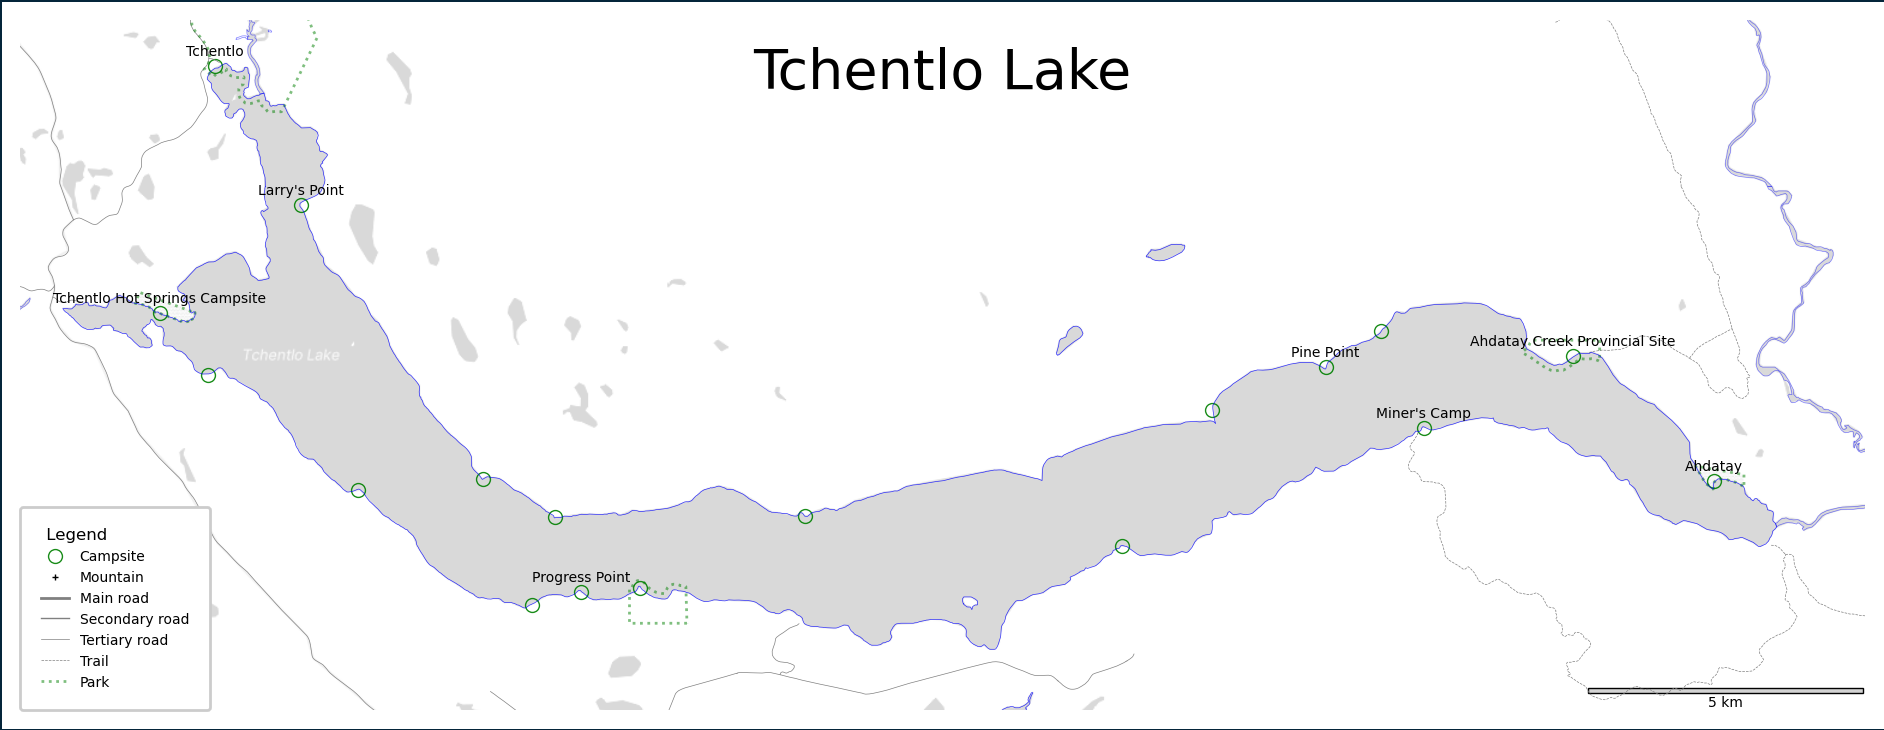

In [15]:
# make fig with backgound tiles
fig,ax = plt.subplots(1, figsize=figsize,linewidth=1, edgecolor="#04253a")
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
fig.set_dpi(200)
ax.set_axis_off() # don't display axes with coordinates

cx.add_basemap(ax, source = tiles_source, zoom=zoom_level);

# Plot features from OSM
for element in elements:
    # get coordinates to plot for this element
    element_type = element["element_type"]
    coords_list = extract_coords(element["geometry"])
    for coords in coords_list:
        x,y = zip(*coords)
        ax.plot(x,y,**get_style(element, tag_styles, styles))
    if (element_type == "node" and type(element["name"])!=float):
        ax.annotate(element["name"], (x[0],y[0]), 
                    size=annotation_text_size, 
                    xycoords='data', 
                    xytext=(0, node_marker_size*0.75), 
                    textcoords='offset points', 
                    ha='center');
# Add legend
legend_items = ["campsite", "mountain", "main_road", "secondary_road", "tertiary_road", "trail", "park"]
legend_styles = {name: styles[name] for name in legend_items}
legend_loc = (0.,0)
ax = add_legend(ax, annotation_text_size, legend_styles, legend_loc)

# Add distance scale bar
plot_width_km = get_plot_width_km(west, east, south, north)
scale_max_width_pct = 0.15

scale_anchor_fig_x = 1-scale_max_width_pct
scale_anchor_fig_y = 0.025
scale_anchor_xy = fig_to_xy(scale_anchor_fig_x, scale_anchor_fig_y,x_min,x_max,y_min,y_max)

ax = add_scale_bar(ax, scale_max_width_pct, scale_anchor_xy, plot_width_km, dx, dy, annotation_text_size)

# Add map title
ax.annotate(place["name"], fig_to_xy(0.5, 0.9, x_min, x_max, y_min, y_max), ha='center', va = "baseline", size=annotation_text_size*4);
plt.tight_layout(pad=1)
# plt.savefig(f'maps/{place_name}.png') 